# Data Analysis 1 - Optimization on ArmV8

## Section 1: File Parsing

### Section 1.1: Reading Log Files

In [1]:
import os
import pandas as pd
import seaborn as sns
import sys 
sys.path.append('/home/zhouzikai/nn_ext_dataflows/data_analysis')
from scripts import build_dataframe
import re


BASELINE_DIR = '/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3'
EXTENDED_DIR = '/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log'

def parse_filename_bl(filename):
    pattern = r"([a-z]{2})_([0-9a-zA-Z]+)_baseline_(\d+)_hw_(\d+)_f_(\d+)_nf_(\d+)_s_(\d+)_(\w+)CPU__stats"
    match = re.match(pattern, filename)

    if match:
        num_bits = match.group(2)
        if num_bits == 'bin':
            num_bits = 1
        elif num_bits == '8bt':
            num_bits = 8
        else:
            raise Exception("number of bits not hardcoded")
            num_bits = int(num_bits)

        return {
            'anchoring_stationary': match.group(1),
            'num_bits': num_bits,
            'vector_length': int(match.group(3)),
            'input_hw': int(match.group(4)),
            'filter_size': int(match.group(5)),
            'num_filters': int(match.group(6)),
            'stride': int(match.group(7)),
            'cpu_type': match.group(8),
        }
    else:
        print(f"unmatched. filename: {filename}")
        return {}
def get_file_size(file_path):
    return os.path.getsize(file_path)

def get_data_size_df_bl(directory):
    file_data = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        parsed_info = parse_filename_bl(filename)
        file_data.append({'file_path': f, 'size': get_file_size(f), **parsed_info})
    df = pd.DataFrame(file_data).set_index('file_path')
    return df

def append_dataframe(df1, df2, join_keyword='filename'):
    '''
    add the 'size' column from df1 to df2, assuming their indices are the same (file path)
    '''
    merged_df = df2.join(df1)

    return merged_df


def parse_filename_ex(filename):
    pattern = r"vl(\d+)_([0-9a-zA-Z]+)_stride_(\d+)_fs_(\d+)_([a-z]{2})((?:_[a-zA-Z]+_\d+)+)_hw_(\d+)_nf_(\d+)_(\w+)CPU__stats"
    match = re.match(pattern, filename)

    if match:
        num_bits = match.group(2)
        if num_bits == 'bin':
            num_bits = 1
        elif num_bits == '8bt':
            num_bits = 8
        else:
            raise Exception("number of bits not hardcoded")
            num_bits = int(num_bits)

        # Parsing and sorting auxiliary stationary and stats pairs
        aux_pairs_str = match.group(6)
        aux_pairs = re.findall(r"_([a-zA-Z]+)_(\d+)", aux_pairs_str)
        sorted_aux_pairs = sorted(aux_pairs, key=lambda x: (x[0], int(x[1])))

        aux_data = {}
        for i, (name, value) in enumerate(sorted_aux_pairs):
            if name not in aux_data:
                aux_data[f'aux_{name}'] = int(value)
            else:
                aux_data[f'aux_{name}_{i + 1}'] = int(value)

        return {
            'vector_length': int(match.group(1)),
            'num_bits': num_bits,
            'stride': int(match.group(3)),
            'filter_size': int(match.group(4)),
            'anchoring_stationary': match.group(5),
            'input_hw': int(match.group(7)),
            'num_filters': int(match.group(8)),
            'cpu_type': match.group(9),
            **aux_data
        }
    else:
        print(f"unmatched. filename: {filename}")
        return {}
def get_file_size(file_path):
    return os.path.getsize(file_path)


def get_data_size_df_ex(directory):
    file_data = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        parsed_info = parse_filename_ex(filename)
        # if (get_file_size(f)) == 0:
        #     # print("found one empty")
        file_data.append({'file_path': f, 'size': get_file_size(f), **parsed_info})
    df = pd.DataFrame(file_data).set_index('file_path')
    return df

# Read Baseline Directory
df_bl = get_data_size_df_bl(BASELINE_DIR)
bl_file_list=[]
for filename in os.listdir(BASELINE_DIR):
   f = os.path.join(BASELINE_DIR, filename)
   bl_file_list.append(f)
df_bl_files = build_dataframe(bl_file_list)
df_bl= append_dataframe(df_bl,df_bl_files)

# Read Extended Directory
df_ex = get_data_size_df_ex(EXTENDED_DIR)
ex_file_list=[]
for filename in os.listdir(EXTENDED_DIR):
   f = os.path.join(EXTENDED_DIR, filename)
   ex_file_list.append(f)
df_ex_files = build_dataframe(ex_file_list)
df_ex= append_dataframe(df_ex,df_ex_files)
df_ex_ana = df_ex

In [2]:
filename = "vl512_8bt_stride_1_fs_3_ws_os_0_is_5_hw_112_nf_8_ArmO3CPU__stats.txt"
result = parse_filename_ex(filename)
print(result)

{'vector_length': 512, 'num_bits': 8, 'stride': 1, 'filter_size': 3, 'anchoring_stationary': 'ws', 'input_hw': 112, 'num_filters': 8, 'cpu_type': 'ArmO3', 'aux_is': 5, 'aux_os': 0}


In [3]:
df_ex

,simSeconds,simTicks,finalTick,simFreq,hostSeconds,hostTickRate,hostMemory,simInsts,simOps,hostInstRate,...,num_bits,stride,filter_size,anchoring_stationary,input_hw,num_filters,cpu_type,aux_os,aux_ws,aux_is
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log/vl512_8bt_stride_2_fs_4_is_ws_0_os_5_hw_56_nf_8_ArmO3CPU__stats.txt,0.002352,2.352289e+09,2.352289e+09,1.000000e+12,36.31,64784832.0,681144.0,10057646.0,12345525.0,276998.0,...,8,2,4,is,56,8,ArmO3,5.0,0.0,NaN
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log/vl512_8bt_stride_2_fs_4_ws_os_0_is_5_hw_112_nf_8_ArmO3CPU__stats.txt,0.025369,2.536906e+10,2.636011e+10,1.000000e+12,92.06,275556616.0,680116.0,10838890.0,13076513.0,117731.0,...,8,2,4,ws,112,8,ArmO3,0.0,NaN,5.0
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log/vl256_8bt_stride_2_fs_4_os_ws_5_is_8_hw_56_nf_16_ArmO3CPU__stats.txt,0.000347,3.473805e+08,1.337178e+09,1.000000e+12,7.24,47956467.0,680116.0,3538547.0,4241953.0,488494.0,...,8,2,4,os,56,16,ArmO3,NaN,5.0,8.0
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log/vl512_8bt_stride_1_fs_5_os_ws_5_is_0_hw_56_nf_32_ArmO3CPU__stats.txt,0.013565,1.356541e+10,1.455434e+10,1.000000e+12,252.28,53770702.0,680124.0,43988994.0,71331706.0,174364.0,...,8,1,5,os,56,32,ArmO3,NaN,5.0,0.0
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log/vl512_8bt_stride_2_fs_5_os_ws_0_is_5_hw_56_nf_8_ArmO3CPU__stats.txt,0.001321,1.321344e+09,2.311426e+09,1.000000e+12,19.77,66848588.0,680120.0,4519972.0,7311776.0,228670.0,...,8,2,5,os,56,8,ArmO3,NaN,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log/vl256_bin_stride_2_fs_5_os_ws_13_is_0_hw_56_nf_16_ArmO3CPU__stats.txt,0.000811,8.106230e+08,1.800217e+09,1.000000e+12,19.30,42011957.0,680120.0,6989825.0,8526483.0,362257.0,...,1,2,5,os,56,16,ArmO3,NaN,13.0,0.0
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log/vl256_8bt_stride_1_fs_5_os_ws_0_is_13_hw_56_nf_8_ArmO3CPU__stats.txt,0.001619,1.619145e+09,2.608906e+09,1.000000e+12,19.02,85135784.0,680124.0,6136026.0,7670229.0,322634.0,...,8,1,5,os,56,8,ArmO3,NaN,0.0,13.0
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log/vl512_bin_stride_2_fs_4_is_ws_0_os_5_hw_56_nf_32_ArmO3CPU__stats.txt,0.008858,8.857878e+09,8.857878e+09,1.000000e+12,141.26,62704678.0,681140.0,43660251.0,51996736.0,309069.0,...,1,2,4,is,56,32,ArmO3,5.0,0.0,NaN
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log/vl512_bin_stride_1_fs_3_is_ws_0_os_5_hw_112_nf_8_ArmO3CPU__stats.txt,0.011117,1.111731e+10,1.111731e+10,1.000000e+12,89.47,124258675.0,681140.0,20395374.0,25352869.0,227960.0,...,1,1,3,is,112,8,ArmO3,5.0,0.0,NaN


In [4]:
df_bl

,simSeconds,simTicks,finalTick,simFreq,hostSeconds,hostTickRate,hostMemory,simInsts,simOps,hostInstRate,...,system.mem_ctrls.rdPerTurnAround::896-1023,size,anchoring_stationary,num_bits,vector_length,input_hw,filter_size,num_filters,stride,cpu_type
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_128_hw_112_f_3_nf_64_s_2_ArmO3CPU__stats.txt,0.056649,5.664908e+10,5.664908e+10,1.000000e+12,280.72,201802520.0,681144.0,42124919.0,42396496.0,150063.0,...,NaN,172399,ws,1,128,112,3,64,2,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_bin_baseline_128_hw_56_f_4_nf_16_s_1_ArmO3CPU__stats.txt,0.004103,4.103061e+09,4.103061e+09,1.000000e+12,53.96,76038771.0,681144.0,21393754.0,21665456.0,396472.0,...,NaN,172141,os,1,128,56,4,16,1,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_512_hw_56_f_3_nf_64_s_2_ArmO3CPU__stats.txt,0.013981,1.398118e+10,1.398118e+10,1.000000e+12,92.45,151236364.0,681140.0,18554340.0,21032824.0,200705.0,...,NaN,172265,ws,1,512,56,3,64,2,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_128_hw_112_f_4_nf_32_s_2_ArmO3CPU__stats.txt,0.047137,4.713684e+10,4.713684e+10,1.000000e+12,242.88,194071399.0,681140.0,37855927.0,38127504.0,155860.0,...,NaN,172137,ws,1,128,112,4,32,2,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_8bt_baseline_512_hw_112_f_5_nf_16_s_2_ArmO3CPU__stats.txt,0.014157,1.415693e+10,1.415693e+10,1.000000e+12,147.49,95987469.0,681144.0,43321281.0,55780535.0,293729.0,...,NaN,171877,os,8,512,112,5,16,2,ArmO3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/is_bin_baseline_128_hw_56_f_3_nf_64_s_1_ArmO3CPU__stats.txt,0.025114,2.511420e+10,2.511420e+10,1.000000e+12,173.58,144682786.0,681144.0,50598563.0,50870169.0,291498.0,...,NaN,172394,is,1,128,56,3,64,1,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_8bt_baseline_128_hw_56_f_3_nf_16_s_2_ArmO3CPU__stats.txt,0.001389,1.388558e+09,1.388558e+09,1.000000e+12,15.11,91923314.0,680116.0,4460928.0,4732103.0,295313.0,...,NaN,171734,os,8,128,56,3,16,2,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_512_hw_112_f_4_nf_32_s_2_ArmO3CPU__stats.txt,0.057760,5.776026e+10,5.776026e+10,1.000000e+12,331.96,174000023.0,681144.0,61456501.0,69615596.0,185135.0,...,NaN,172013,ws,1,512,112,4,32,2,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_8bt_baseline_512_hw_56_f_4_nf_8_s_2_ArmO3CPU__stats.txt,0.001794,1.793547e+09,1.793547e+09,1.000000e+12,19.46,92150946.0,681144.0,5166835.0,6405958.0,265466.0,...,NaN,171874,os,8,512,56,4,8,2,ArmO3


In [5]:
len(df_bl)

864

In [6]:
len(df_ex)

1176

### Section 2.2: Filtering to Useful Columns Only

In [7]:
COL_FILTER = ["simSeconds","simInsts","simOps","vector_length","num_bits","stride","filter_size","anchoring_stationary","input_hw","num_filters"]

REF_COLS = ["simSeconds","simInsts","simOps","vector_length","num_bits","stride","filter_size","anchoring_stationary","input_hw","num_filters","system.cpu.dcache.demandMissRate::cpu.data","system.cpu.dcache.demandAvgMissLatency::total","system.cpu.dcache.writebacks::total","system.mem_ctrls.dram.numReads::cpu.data","system.mem_ctrls.dram.numWrites::total"]

df_bl = df_bl[COL_FILTER]
df_ex = df_ex[COL_FILTER]

In [8]:
df_ex = df_ex.groupby(['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',"anchoring_stationary"]).min()

In [9]:
df_bl

,simSeconds,simInsts,simOps,vector_length,num_bits,stride,filter_size,anchoring_stationary,input_hw,num_filters
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_128_hw_112_f_3_nf_64_s_2_ArmO3CPU__stats.txt,0.056649,42124919.0,42396496.0,128,1,2,3,ws,112,64
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_bin_baseline_128_hw_56_f_4_nf_16_s_1_ArmO3CPU__stats.txt,0.004103,21393754.0,21665456.0,128,1,1,4,os,56,16
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_512_hw_56_f_3_nf_64_s_2_ArmO3CPU__stats.txt,0.013981,18554340.0,21032824.0,512,1,2,3,ws,56,64
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_128_hw_112_f_4_nf_32_s_2_ArmO3CPU__stats.txt,0.047137,37855927.0,38127504.0,128,1,2,4,ws,112,32
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_8bt_baseline_512_hw_112_f_5_nf_16_s_2_ArmO3CPU__stats.txt,0.014157,43321281.0,55780535.0,512,8,2,5,os,112,16
...,...,...,...,...,...,...,...,...,...,...
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/is_bin_baseline_128_hw_56_f_3_nf_64_s_1_ArmO3CPU__stats.txt,0.025114,50598563.0,50870169.0,128,1,1,3,is,56,64
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_8bt_baseline_128_hw_56_f_3_nf_16_s_2_ArmO3CPU__stats.txt,0.001389,4460928.0,4732103.0,128,8,2,3,os,56,16
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_512_hw_112_f_4_nf_32_s_2_ArmO3CPU__stats.txt,0.057760,61456501.0,69615596.0,512,1,2,4,ws,112,32
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_8bt_baseline_512_hw_56_f_4_nf_8_s_2_ArmO3CPU__stats.txt,0.001794,5166835.0,6405958.0,512,8,2,4,os,56,8


In [10]:
df_ex

simSeconds   
vector_length num_bits stride filter_size input_hw num_filters anchoring_stationary               
128           1        1      3           56       8           is                      0.001337  \
                                                               os                      0.000399   
                                                               ws                      0.000556   
                                                   16          is                      0.002862   
                                                               os                      0.001628   
...                                                                                         ...   
512           8        2      5           112      16          os                      0.012006   
                                                               ws                      0.079205   
                                                   32          is                      0.045592   
                                                               os                      0.024336   
                                                               ws                      0.158371   

                                                                                        simInsts   
vector_length num_bits stride filter_size input_hw num_filters anchoring_stationary                
128           1        1      3           56       8           is                      3516983.0  \
                                                               os                      3052265.0   
                                                               ws                      3291910.0   
                                                   16          is                      5366576.0   
                                                               os                      4447250.0   
...                                                                                          ...   
512           8        2      5           112      16          os                     23608525.0   
                                                               ws                     30324048.0   
                                                   32          is                    235165637.0   
                                                               os                     45559569.0   
                                                               ws                     58990644.0   

                                                                                          simOps  
vector_length num_bits stride filter_size input_hw num_filters anchoring_stationary               
128           1        1      3           56       8           is                      3788095.0  
                                                               os                      3321413.0  
                                                               ws                      3682103.0  
                                                   16          is                      5637768.0  
                                                               os                      4716462.0  
...                                                                                          ...  
512           8        2      5           112      16          os                     41681729.0  
                                                               ws                     36745720.0  
                                                   32          is                    286110599.0  
                                                               os                     81436901.0  
                                                               ws                     71564876.0  

[648 rows x 3 columns]

### Section 2.3: Merging baseline and optimized dataframes

In [11]:
df_ex = df_ex.rename(columns={"simSeconds":"simSeconds_opt","simInsts":"simInsts_opt","simOps":"simOps_opt"})
df_merged = pd.merge(df_ex,df_bl,how='left',\
                    left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',"anchoring_stationary"],\
                    right_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',"anchoring_stationary"])

In [12]:
NUM_FILTER_LOWER = 8
NUM_FILTER_UPPER = 32
VEC_LEN_LIST = [128,256,512]

In [13]:
df_merged

,vector_length,num_bits,stride,filter_size,input_hw,num_filters,anchoring_stationary,simSeconds_opt,simInsts_opt,simOps_opt,simSeconds,simInsts,simOps
0,128,1,1,3,56,8,is,0.001337,3516983.0,3788095.0,0.002728,7786158.0,8057764.0
1,128,1,1,3,56,8,os,0.000399,3052265.0,3321413.0,0.001901,7649254.0,7920915.0
2,128,1,1,3,56,8,ws,0.000556,3291910.0,3682103.0,0.002117,6695706.0,6967312.0
3,128,1,1,3,56,16,is,0.002862,5366576.0,5637768.0,0.006385,13902231.0,14173837.0
4,128,1,1,3,56,16,os,0.001628,4447250.0,4716462.0,0.003189,13628103.0,13899772.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,512,8,2,5,112,16,os,0.012006,23608525.0,41681729.0,0.014157,43321281.0,55780535.0
644,512,8,2,5,112,16,ws,0.079205,30324048.0,36745720.0,0.047138,41873205.0,48240380.0
645,512,8,2,5,112,32,is,0.045592,235165637.0,286110599.0,0.083684,349623476.0,401008171.0
646,512,8,2,5,112,32,os,0.024336,45559569.0,81436901.0,0.027347,84974677.0,109622091.0


In [14]:
df_merged = df_merged[(df_merged["num_filters"]>= NUM_FILTER_LOWER) &(df_merged["num_filters"]<= NUM_FILTER_UPPER)& (df_merged["vector_length"].isin(VEC_LEN_LIST)) & (df_merged["stride"]==1)]

<Axes: xlabel='simSeconds'>

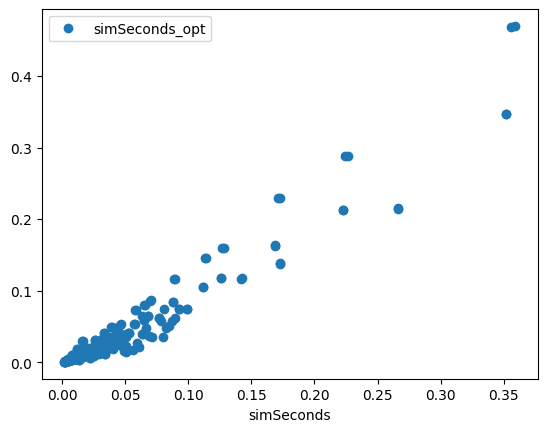

In [15]:
df_merged.plot(x="simSeconds",y="simSeconds_opt",style=['o','rx'])

## Section 2: Calculating Improvments

In [16]:
df_merged["improvement"] = df_merged["simSeconds"]/df_merged["simSeconds_opt"]

/tmp/ipykernel_500530/1120125696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged["improvement"] = df_merged["simSeconds"]/df_merged["simSeconds_opt"]


(array([ 0.,  0.,  5., 33., 55., 51., 51., 42., 34., 15., 12., 13.,  2.,
         0.,  2.,  5.,  0.,  0.,  0.,  2.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <BarContainer object of 20 artists>)

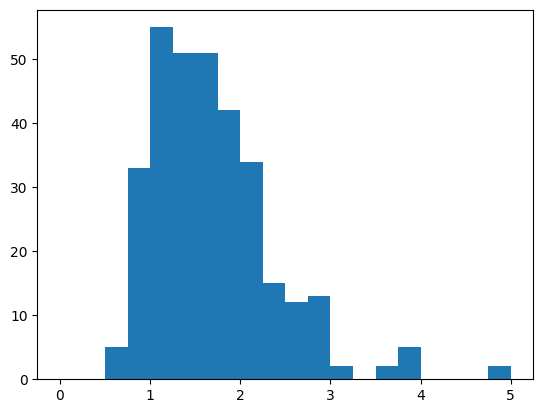

In [17]:
import matplotlib.pyplot as plt

plt.hist(df_merged['improvement'], range=[0, 5],bins=20)

(array([ 0.,  0.,  0.,  0.,  3., 25., 30., 11., 13.,  8.,  8.,  7.,  2.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <BarContainer object of 20 artists>)

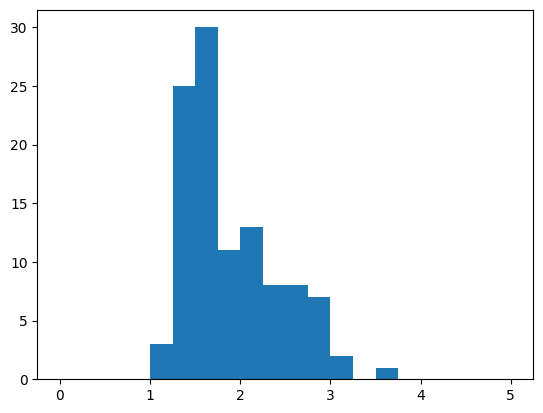

In [18]:
plt.hist(df_merged[df_merged["anchoring_stationary"]=='is']['improvement'], range=[0, 5],bins=20)

(array([ 0.,  0.,  0.,  2., 16., 12., 16., 28., 21.,  5.,  3.,  1.,  0.,
         0.,  1.,  1.,  0.,  0.,  0.,  2.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <BarContainer object of 20 artists>)

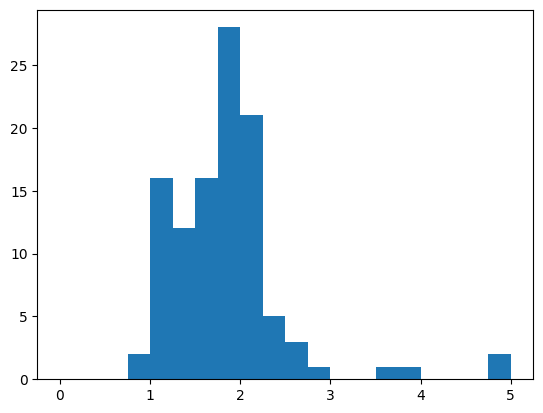

In [19]:
plt.hist(df_merged[df_merged["anchoring_stationary"]=='os']['improvement'], range=[0, 5],bins=20)

(array([ 0.,  0.,  5., 31., 36., 14.,  5.,  3.,  0.,  2.,  1.,  5.,  0.,
         0.,  0.,  4.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <BarContainer object of 20 artists>)

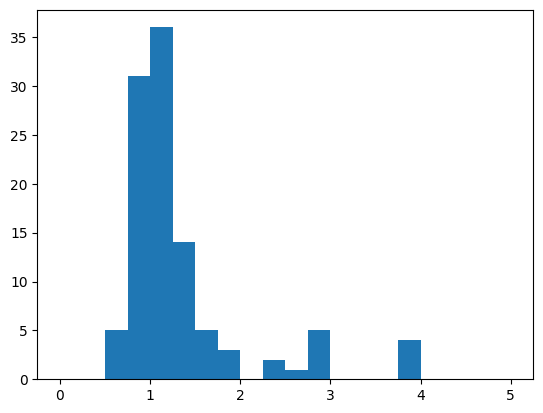

In [20]:
plt.hist(df_merged[df_merged["anchoring_stationary"]=='ws']['improvement'], range=[0, 5],bins=20)

In [21]:
df_merged['improvement'].mean()

1.7105954089697584

In [22]:
df_merged['improvement'].median()

1.6013142147524293

In [23]:
len(df_merged["vector_length"]==128)

324

In [24]:
len(df_merged["vector_length"]==256)

324

In [25]:
len(df_merged["vector_length"]==512)

324

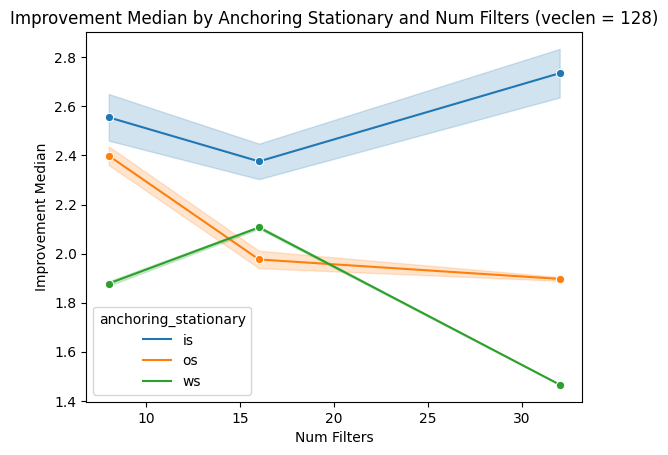

In [26]:
grouped_df = df_merged.groupby(["anchoring_stationary","num_filters","vector_length","num_bits"])["improvement"].median().reset_index()
sns.lineplot(data=grouped_df[(grouped_df["vector_length"]==128)], x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters (veclen = 128)'
)
plt.show()

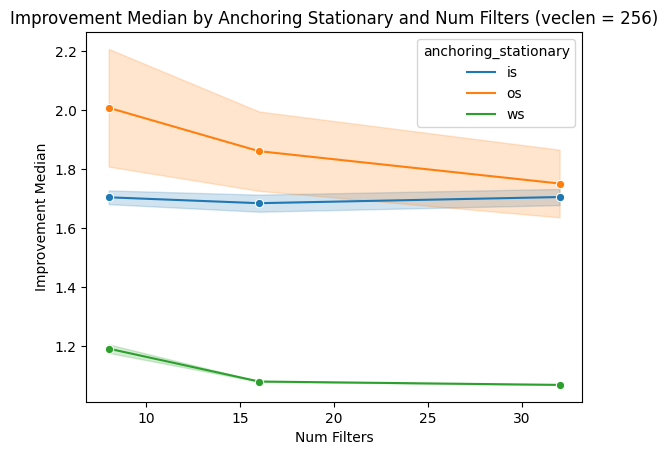

In [27]:
sns.lineplot(data=grouped_df[grouped_df["vector_length"]==256], x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters (veclen = 256)'
)
plt.show()

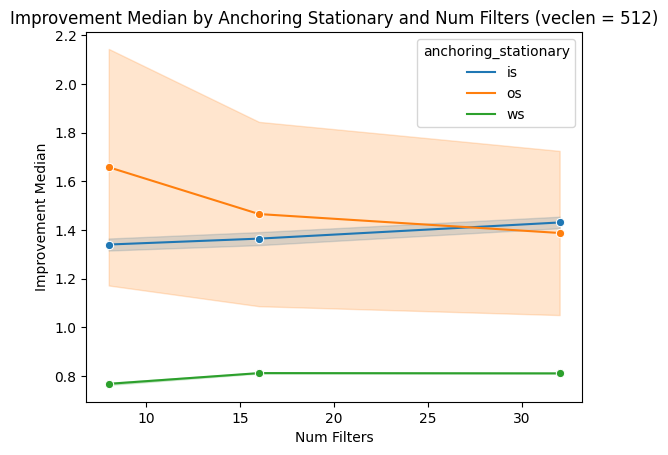

In [28]:
sns.lineplot(data=grouped_df[grouped_df["vector_length"]==512], x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters (veclen = 512)'
)
plt.show()

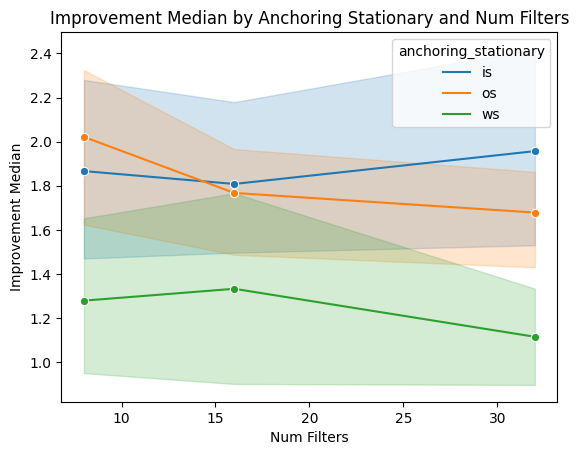

In [29]:
grouped_df = df_merged.groupby(["anchoring_stationary","num_filters","vector_length","num_bits"])["improvement"].median().reset_index()
sns.lineplot(data=grouped_df, x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters'
)
plt.show()

In [30]:
def calculate_is_ws_difference(group):
    ws_value = group.loc[group['anchoring_stationary'] == 'ws', 'simSeconds_opt'].min()
    is_value = group.loc[group['anchoring_stationary'] == 'is', 'simSeconds_opt'].min()
    return (ws_value - is_value) / is_value

def calculate_os_ws_difference(group):
    ws_value = group.loc[group['anchoring_stationary'] == 'ws', 'simSeconds_opt'].min()
    os_value = group.loc[group['anchoring_stationary'] == 'os', 'simSeconds_opt'].min()
    return (ws_value - os_value) / os_value


def calculate_is_os_difference(group):
    is_value = group.loc[group['anchoring_stationary'] == 'is', 'simSeconds_opt'].min()
    os_value = group.loc[group['anchoring_stationary'] == 'os', 'simSeconds_opt'].min()
    return (is_value - os_value) / os_value

In [31]:
is_ws_diff = df_merged.groupby(['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters']).apply(calculate_is_ws_difference).reset_index(name='is_ws_difference')

os_ws_diff = df_merged.groupby(['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters']).apply(calculate_os_ws_difference).reset_index(name='os_ws_difference')

is_os_diff = df_merged.groupby(['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters']).apply(calculate_is_os_difference).reset_index(name='is_os_difference')

<Axes: >

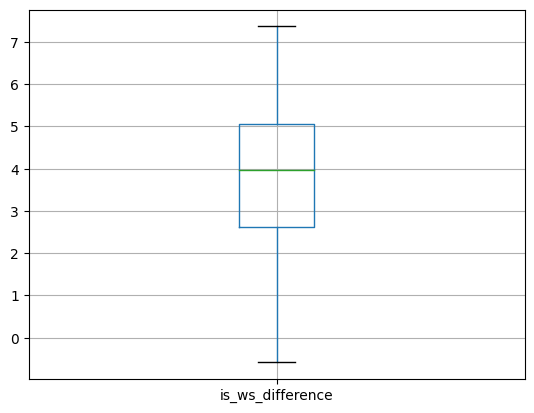

In [32]:
is_ws_diff.boxplot(column="is_ws_difference")

<Axes: >

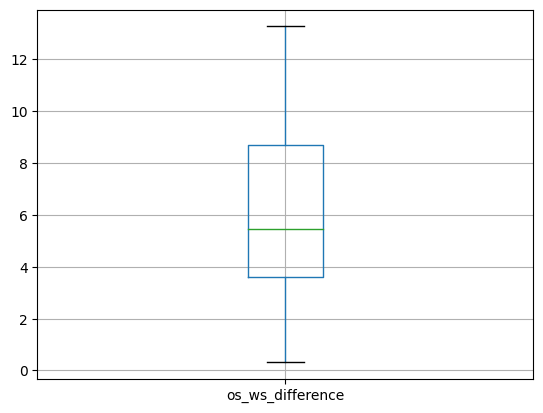

In [33]:
os_ws_diff.boxplot(column="os_ws_difference")

<Axes: >

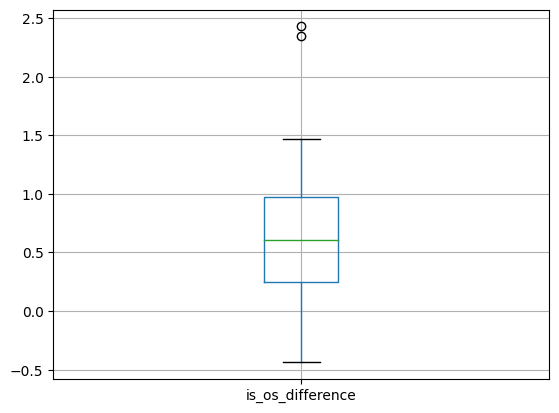

In [34]:
is_os_diff.boxplot(column="is_os_difference")

In [35]:
len(is_os_diff[is_os_diff["is_os_difference"]<=0])/len(is_os_diff[is_os_diff["is_os_difference"].notna()])

0.12037037037037036

### Analyzing Baselines

In [36]:
df_bl_is = df_bl[df_bl["anchoring_stationary"]=="is"]
df_bl_os = df_bl[df_bl["anchoring_stationary"]=="os"]
df_bl_ws = df_bl[df_bl["anchoring_stationary"]=="ws"]

In [37]:
df_bl_is = df_bl_is.rename(columns={"simSeconds":"simSeconds_is","simInsts":"simInsts_is","simOps":"simOps_is"})
df_bl_os = df_bl_os.rename(columns={"simSeconds":"simSeconds_os","simInsts":"simInsts_os","simOps":"simOps_os"})
df_bl_ws = df_bl_ws.rename(columns={"simSeconds":"simSeconds_ws","simInsts":"simInsts_ws","simOps":"simOps_ws"})

In [38]:
df_bl_db = pd.merge(df_bl_is,df_bl_os,how='left', left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',], right_on = ['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters'])
df_bl_db

,simSeconds_is,simInsts_is,simOps_is,vector_length,num_bits,stride,filter_size,anchoring_stationary_x,input_hw,num_filters,simSeconds_os,simInsts_os,simOps_os,anchoring_stationary_y
0,0.017861,67827612.0,73104275.0,256,8,2,5,is,56,32,0.003716,17734332.0,20372914.0,os
1,0.008540,31154349.0,33411072.0,256,1,2,3,is,56,32,0.002488,8803833.0,9957343.0,os
2,0.004804,13702812.0,14784495.0,256,1,1,4,is,56,8,0.003328,13433136.0,15225598.0,os
3,0.025354,59709872.0,63867203.0,256,1,1,3,is,56,64,0.010226,58213276.0,65454626.0,os
4,0.064387,197878337.0,211455543.0,256,1,1,4,is,112,32,0.037942,189695501.0,214973782.0,os
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.002639,8370379.0,9137945.0,256,8,2,3,is,56,8,0.001280,3284963.0,3776576.0,os
284,0.022904,51120183.0,51391760.0,128,1,1,3,is,112,16,0.009900,49167118.0,49438791.0,os
285,0.188082,310741427.0,311012522.0,128,8,1,5,is,112,64,0.060581,432072062.0,432343156.0,os
286,0.032718,99773118.0,106697268.0,256,1,1,4,is,112,16,0.019546,95683002.0,108457971.0,os


In [39]:
df_bl_tp = pd.merge(df_bl_db,df_bl_ws,how='left', left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',], right_on = ['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters'])
df_bl_tp

,simSeconds_is,simInsts_is,simOps_is,vector_length,num_bits,stride,filter_size,anchoring_stationary_x,input_hw,num_filters,simSeconds_os,simInsts_os,simOps_os,anchoring_stationary_y,simSeconds_ws,simInsts_ws,simOps_ws,anchoring_stationary
0,0.017861,67827612.0,73104275.0,256,8,2,5,is,56,32,0.003716,17734332.0,20372914.0,os,0.006335,17080178.0,18536617.0,ws
1,0.008540,31154349.0,33411072.0,256,1,2,3,is,56,32,0.002488,8803833.0,9957343.0,os,0.004044,7907847.0,8620925.0,ws
2,0.004804,13702812.0,14784495.0,256,1,1,4,is,56,8,0.003328,13433136.0,15225598.0,os,0.011012,12472358.0,13504604.0,ws
3,0.025354,59709872.0,63867203.0,256,1,1,3,is,56,64,0.010226,58213276.0,65454626.0,os,0.048583,50525610.0,54283168.0,ws
4,0.064387,197878337.0,211455543.0,256,1,1,4,is,112,32,0.037942,189695501.0,214973782.0,os,0.222222,174777531.0,187553428.0,ws
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.002639,8370379.0,9137945.0,256,8,2,3,is,56,8,0.001280,3284963.0,3776576.0,os,0.001410,3062121.0,3443655.0,ws
284,0.022904,51120183.0,51391760.0,128,1,1,3,is,112,16,0.009900,49167118.0,49438791.0,os,0.053352,41638683.0,41910260.0,ws
285,0.188082,310741427.0,311012522.0,128,8,1,5,is,112,64,0.060581,432072062.0,432343156.0,os,0.510858,406092468.0,406363565.0,ws
286,0.032718,99773118.0,106697268.0,256,1,1,4,is,112,16,0.019546,95683002.0,108457971.0,os,0.111791,88223768.0,94747505.0,ws


In [40]:
df_bl_tp["is_over_os"] = df_bl_tp["simSeconds_is"] / df_bl_tp["simSeconds_os"]

In [41]:
len(df_bl_tp[df_bl_tp["is_over_os"]>=1])/len(df_bl_tp)

1.0

In [42]:
df_bl_tp["ws_over_os"] = df_bl_tp["simSeconds_ws"] / df_bl_tp["simSeconds_os"]

In [43]:
df_bl_tp["ws_over_is"] = df_bl_tp["simSeconds_ws"] / df_bl_tp["simSeconds_is"]

<Axes: >

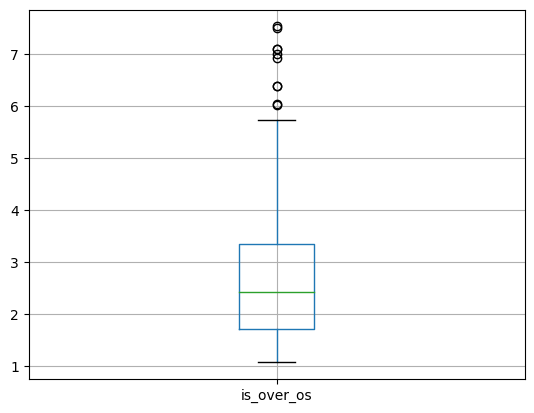

In [44]:
df_bl_tp.boxplot(column="is_over_os")

<Axes: >

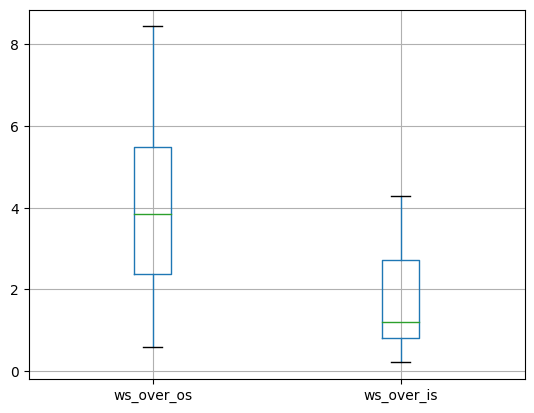

In [45]:
df_bl_tp.boxplot(column=["ws_over_os","ws_over_is"])

In [46]:
len(df_bl_tp[df_bl_tp["ws_over_os"]>=1])/len(df_bl_tp)

0.96875

In [47]:
len(df_bl_tp[df_bl_tp["ws_over_is"]>=1])/len(df_bl_tp)

0.6180555555555556

In [48]:
df_ex

simSeconds_opt   
vector_length num_bits stride filter_size input_hw num_filters anchoring_stationary                   
128           1        1      3           56       8           is                          0.001337  \
                                                               os                          0.000399   
                                                               ws                          0.000556   
                                                   16          is                          0.002862   
                                                               os                          0.001628   
...                                                                                             ...   
512           8        2      5           112      16          os                          0.012006   
                                                               ws                          0.079205   
                                                   32          is                          0.045592   
                                                               os                          0.024336   
                                                               ws                          0.158371   

                                                                                     simInsts_opt   
vector_length num_bits stride filter_size input_hw num_filters anchoring_stationary                 
128           1        1      3           56       8           is                       3516983.0  \
                                                               os                       3052265.0   
                                                               ws                       3291910.0   
                                                   16          is                       5366576.0   
                                                               os                       4447250.0   
...                                                                                           ...   
512           8        2      5           112      16          os                      23608525.0   
                                                               ws                      30324048.0   
                                                   32          is                     235165637.0   
                                                               os                      45559569.0   
                                                               ws                      58990644.0   

                                                                                      simOps_opt  
vector_length num_bits stride filter_size input_hw num_filters anchoring_stationary               
128           1        1      3           56       8           is                      3788095.0  
                                                               os                      3321413.0  
                                                               ws                      3682103.0  
                                                   16          is                      5637768.0  
                                                               os                      4716462.0  
...                                                                                          ...  
512           8        2      5           112      16          os                     41681729.0  
                                                               ws                     36745720.0  
                                                   32          is                    286110599.0  
                                                               os                     81436901.0  
                                                               ws                     71564876.0  

[648 rows x 3 columns]

### Auxiliary Analysis

In [49]:
is_anchored = df_ex_ana[df_ex_ana["anchoring_stationary"]=="is"]
os_anchored = df_ex_ana[df_ex_ana["anchoring_stationary"]=="os"]
ws_anchored = df_ex_ana[df_ex_ana["anchoring_stationary"]=="ws"]

In [50]:
is_anchored["prefer_ws"] = (is_anchored["aux_ws"] == is_anchored["filter_size"] * is_anchored["filter_size"]) | ((is_anchored["aux_os"] == 0) & (is_anchored["aux_ws"] > 0))

is_anchored["prefer_os"] =(is_anchored["aux_os"] == is_anchored["filter_size"] * (is_anchored["filter_size"] - is_anchored["stride"])) | ((is_anchored["aux_os"] > 0) & (is_anchored["aux_ws"] == 0))

os_anchored["prefer_ws"] = (os_anchored["aux_ws"] == os_anchored["filter_size"] * os_anchored["filter_size"])  | ((os_anchored["aux_is"] == 0) & (os_anchored["aux_ws"] > 0))

os_anchored["prefer_is"] = (os_anchored["aux_is"] != os_anchored["filter_size"] * (os_anchored["filter_size"] - os_anchored["stride"])) | ((os_anchored["aux_is"] > 0) & (os_anchored["aux_ws"] == 0))

ws_anchored["prefer_is"] = ws_anchored["aux_os"] == 0
ws_anchored["prefer_os"] = ws_anchored["aux_is"] == 0

/tmp/ipykernel_500530/1436946333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  is_anchored["prefer_ws"] = (is_anchored["aux_ws"] == is_anchored["filter_size"] * is_anchored["filter_size"]) | ((is_anchored["aux_os"] == 0) & (is_anchored["aux_ws"] > 0))
/tmp/ipykernel_500530/1436946333.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  is_anchored["prefer_os"] =(is_anchored["aux_os"] == is_anchored["filter_size"] * (is_anchored["filter_size"] - is_anchored["stride"])) | ((is_anchored["aux_os"] > 0) & (

In [51]:
df_is_aux = pd.merge(is_anchored[is_anchored["prefer_ws"]].rename(columns={"simSeconds":"simSeconds_pws"}),is_anchored[is_anchored["prefer_os"]].rename(columns={"simSeconds":"simSeconds_pos"}),how='left', left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',], right_on = ['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters'])

df_os_aux = pd.merge(os_anchored[os_anchored["prefer_is"]].rename(columns={"simSeconds":"simSeconds_pis"}),os_anchored[os_anchored["prefer_ws"]].rename(columns={"simSeconds":"simSeconds_pws"}),how='left', left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',], right_on = ['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters'])

df_ws_aux = pd.merge(ws_anchored[ws_anchored["prefer_is"]].rename(columns={"simSeconds":"simSeconds_pis"}),ws_anchored[ws_anchored["prefer_os"]].rename(columns={"simSeconds":"simSeconds_pos"}),how='left', left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',], right_on = ['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters'])

In [52]:
df_is_aux["ws_faster"]= (df_is_aux["simSeconds_pws"] - df_is_aux["simSeconds_pos"]) < 0
df_os_aux["ws_faster"]= (df_os_aux["simSeconds_pws"] - df_os_aux["simSeconds_pis"]) < 0
df_ws_aux["os_faster"]= (df_ws_aux["simSeconds_pos"] - df_ws_aux["simSeconds_pis"]) < 0

In [53]:
len(df_is_aux[df_is_aux["ws_faster"]]) / (len(df_is_aux[df_is_aux["ws_faster"]])+ len(df_is_aux[df_is_aux["ws_faster"]==False]))

0.19907407407407407

In [54]:
df_is_aux["os_faster"]= (df_is_aux["simSeconds_pos"] - df_is_aux["simSeconds_pws"]) < 0

In [55]:
len(df_is_aux[df_is_aux["os_faster"]]) / (len(df_is_aux[df_is_aux["os_faster"]])+ len(df_is_aux[df_is_aux["os_faster"]==False]))

0.4537037037037037

In [56]:
len(df_ws_aux[df_ws_aux["os_faster"]]) / (len(df_ws_aux[df_ws_aux["os_faster"]])+ len(df_ws_aux[df_ws_aux["os_faster"]==False]))

0.9537037037037037

In [57]:
df_is_aux["ws_faster_mag"]= (df_is_aux["simSeconds_pws"] - df_is_aux["simSeconds_pos"])/df_is_aux["simSeconds_pos"]

<Axes: >

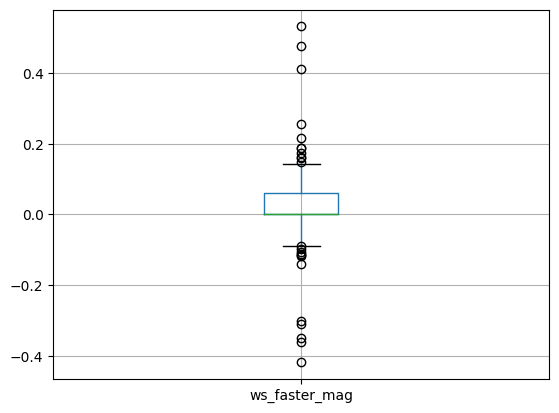

In [58]:
df_is_aux.boxplot(column="ws_faster_mag")

In [59]:
df_is_aux

,simSeconds_pws,simTicks_x,finalTick_x,simFreq_x,hostSeconds_x,hostTickRate_x,hostMemory_x,simInsts_x,simOps_x,hostInstRate_x,...,anchoring_stationary_y,cpu_type_y,aux_os_y,aux_ws_y,aux_is_y,prefer_ws_y,prefer_os_y,ws_faster,os_faster,ws_faster_mag
0,0.012434,1.243365e+10,1.243365e+10,1.000000e+12,139.40,89197028.0,681152.0,43355668.0,46031986.0,311026.0,...,is,ArmO3,13.0,0.0,NaN,False,True,True,False,-0.033126
1,0.010896,1.089598e+10,1.089598e+10,1.000000e+12,107.55,101311620.0,681148.0,32283689.0,32554942.0,300176.0,...,is,ArmO3,20.0,9.0,NaN,False,True,False,True,0.106193
2,0.013626,1.362577e+10,1.362577e+10,1.000000e+12,229.44,59387057.0,681152.0,83114376.0,93596005.0,362248.0,...,is,ArmO3,5.0,0.0,NaN,False,True,False,True,0.036592
3,0.012118,1.211808e+10,1.211808e+10,1.000000e+12,138.00,87811431.0,681148.0,39851698.0,45688055.0,288778.0,...,is,ArmO3,5.0,0.0,NaN,False,True,True,False,-0.054684
4,0.006882,6.881535e+09,6.881535e+09,1.000000e+12,96.51,71302651.0,681140.0,26214829.0,28540625.0,271623.0,...,is,ArmO3,13.0,0.0,NaN,False,True,True,False,-0.057777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,is,ArmO3,15.0,14.0,NaN,False,True,False,False,NaN
212,0.010867,1.086662e+10,1.086662e+10,1.000000e+12,83.03,130869400.0,681148.0,22655685.0,25167835.0,272848.0,...,is,ArmO3,5.0,0.0,NaN,False,True,True,False,-0.002295
213,0.012493,1.249336e+10,1.249336e+10,1.000000e+12,218.08,57288542.0,681148.0,81570595.0,91880104.0,374043.0,...,is,ArmO3,5.0,0.0,NaN,False,True,False,True,0.037883
214,0.057613,5.761312e+10,5.761312e+10,1.000000e+12,859.15,67058002.0,681160.0,252236233.0,291913101.0,293587.0,...,is,ArmO3,5.0,0.0,NaN,False,True,True,False,-0.418280


In [60]:
df_os_aux["ws_faster_mag"]= (df_os_aux["simSeconds_pws"] - df_os_aux["simSeconds_pis"])/df_os_aux["simSeconds_pis"]

<Axes: >

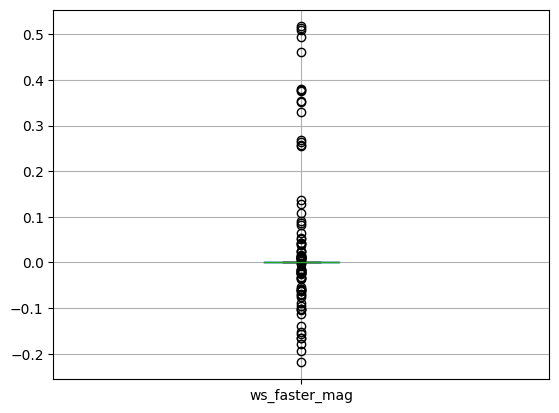

In [61]:
df_os_aux.boxplot(column="ws_faster_mag")